In [1]:
import os
import scipy.io as scio
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
from skyfield.api import EarthSatellite,load, wgs84
from skyfield.elementslib import osculating_elements_of
from pytz import timezone
from matplotlib.colors import cnames
from tqdm import tqdm
from multiprocessing import Pool
import statsmodels.api as sm
from matplotlib.pyplot import MultipleLocator

UTC = timezone('UTC')


In [2]:
tle_path='./data/'
debris_case=tle_path+'228.csv'
starttime=datetime.strptime("2022-4-1 0:0:0","%Y-%m-%d %H:%M:%S")
endtime=datetime.strptime("2022-7-20 0:0:0","%Y-%m-%d %H:%M:%S")
delta_time=(endtime-starttime).days*24*3600
data={}
sattle=pd.read_csv(debris_case)
sattle['EPOCH']=sattle['EPOCH'].astype('datetime64[ns]')
temp=sattle[((sattle['EPOCH']>starttime)&(sattle['EPOCH']<endtime))]
temp=temp.sort_values(by="EPOCH")
temp=temp.drop_duplicates(subset=['EPOCH'])
temp['height']=temp.apply(lambda x:x['SEMIMAJOR_AXIS']-6378.135,axis=1)
satid=list(temp['NORAD_CAT_ID'])[0]
satname=list(temp['OBJECT_NAME'])[0]
data['Ground Truth']=temp['height']

epoch=list(temp['EPOCH'])
i=1
heights=list(temp['height'])[0:i]
ts = load.timescale()
for row in temp.itertuples():
    satellite = EarthSatellite(row.TLE_LINE1, row.TLE_LINE2, 'ISS (ZARYA)', ts)
    heights_temp=[]
    for second in range(0,(epoch[i]-row.EPOCH).days*24*3600+(epoch[i]-row.EPOCH).seconds,60):
        tt=row.EPOCH+timedelta(seconds=second)
        t = ts.utc(tt.year,tt.month,tt.day,tt.hour,tt.minute,tt.second)        
        geocentric = satellite.at(t)     
        height = wgs84.height_of(geocentric)
        heights_temp.append(height.km)
    i+=1
    if len(heights)==1:
        delta=np.mean(heights_temp)-list(data['Ground Truth'])[1]
    heights.append(np.mean(heights_temp)-delta)
    if i==len(epoch):
        break
data['SGP4 w/ updated TLE']=heights

temp=sattle[(sattle['EPOCH']<starttime)]
temp=temp.sort_values(by="EPOCH")
begin_tle=temp.loc[temp.index[-1]]
ts = load.timescale()
Satellite = EarthSatellite(begin_tle['TLE_LINE1'], begin_tle['TLE_LINE2'], 'ISS (ZARYA)', ts)
heights=[]
i=0
temp_height=[]
for seconds in tqdm(range(0,delta_time,60)):
    # t=begin_tle['EPOCH']+timedelta(seconds=seconds)
    t=starttime+timedelta(seconds=seconds)
    tt = UTC.localize(t)
    t_s = ts.from_datetime(tt)
    geocentric = Satellite.at(t_s)
    height = wgs84.height_of(geocentric)
    if i+1==len(epoch):
        temp_height.append(height.km)
    elif t>epoch[i] and t<epoch[i+1]:
        temp_height.append(height.km)
        
    elif t>epoch[i+1]:
        if len(heights)==0:
            delta=np.mean(temp_height)-list(data['Ground Truth'])[0]
        heights.append(np.mean(temp_height)-delta)
        temp_height=[]
        i+=1
heights.append(np.mean(temp_height)-delta)
data['SGP4 w/o updated TLE']=heights

KeyboardInterrupt: 

/var/folders/8c/lhywgg_15jz7c8cs4r3cn1wr0000gn/T/ipykernel_78808/2438715075.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(epoch[:-2],data['Ground Truth'][:-2],label=label[0],c=c[0],lw=4)


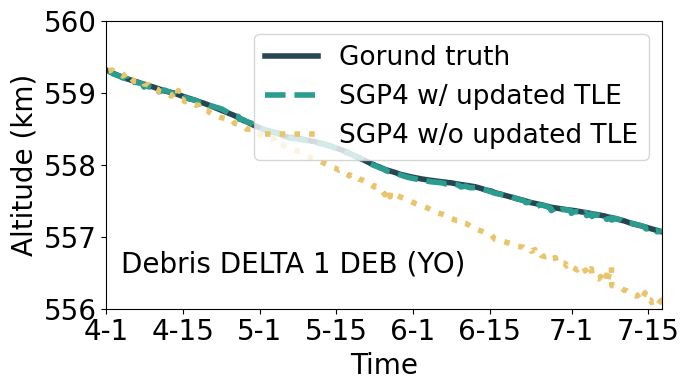

In [5]:
plt.figure(figsize=(7,4))
c=['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51',"#3F72AF","#112D4E"]
i=0
label=['Gorund truth','SGP4 w/ updated TLE', 'SGP4 w/o updated TLE']
plt.ylim([556,560])

plt.plot(epoch[:-2],data['Ground Truth'][:-2],label=label[0],c=c[0],lw=4)
plt.plot(epoch[:-2],data['SGP4 w/ updated TLE'][:-2],label=label[1],c=c[1],lw=4,linestyle='--')
plt.plot(epoch[:-2],data['SGP4 w/o updated TLE'][:-2],label=label[2],c=c[2],lw=4,linestyle=':')

plt.xlim(starttime,epoch[-3])
plt.legend(fontsize=19,loc='upper right')
plt.xlabel('Time',fontsize=20)
plt.ylabel('Altitude (km)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(range(556,561),range(556,561),fontsize=20)
plt.text(starttime+timedelta(days=3),556.5,'Debris DELTA 1 DEB (YO)',fontsize=20)
plt.xticks([starttime,starttime+timedelta(days=15),starttime+timedelta(days=30),starttime+timedelta(days=45),starttime+timedelta(days=60),starttime+timedelta(days=75),starttime+timedelta(days=91),starttime+timedelta(days=106)],['4-1','4-15','5-1','5-15','6-1','6-15','7-1','7-15'])
plt.tight_layout()
plt.savefig('SGP4-accuracy-v2.pdf')